Demo script to analyze experiments results

In [2]:
import os
import pandas as pd

In [60]:
datasets = ["metabric-pam50", "lung", "toxicity", "cll", "smk", "prostate"]

In [61]:
# itearte all folders in the experiment folder
for dataset in datasets:
	print(f'[DATASET: {dataset}]')
	for method in ["original", "crm", "crm_supcon", "crm_supcon_rf"]:
		experiment_name = f"{dataset}_{method}_v2"
		print(f'Results {experiment_name}')
		train_balanced_accs, valid_balanced_acc, test_balanced_acc = [], [], []
		train_aucs, valid_auc, test_auc = [], [], []
		train_mccs, valid_mcc, test_mcc = [], [], []
		train_eces, valid_ece, test_ece = [], [], []

		for folder in os.listdir(os.path.join('logs', experiment_name)):
			metrics = pd.read_csv(os.path.join('logs', experiment_name, folder, 'metrics.csv'))

			# each column 'bestmodel_train/bestmodel_valid/bestmodel_test' contains only one non-zero entry
			# 	which is computed at the end of the experiment
			train_balanced_accs.append(metrics['bestmodel_train/balanced_accuracy'].max())
			valid_balanced_acc.append(metrics['bestmodel_valid/balanced_accuracy'].max())
			test_balanced_acc.append(metrics['bestmodel_test/balanced_accuracy'].max())

			train_aucs.append(metrics['bestmodel_train/aucroc_macro'].max())
			valid_auc.append(metrics['bestmodel_valid/aucroc_macro'].max())
			test_auc.append(metrics['bestmodel_test/aucroc_macro'].max())

			train_mccs.append(metrics['bestmodel_train/mcc'].max())
			valid_mcc.append(metrics['bestmodel_valid/mcc'].max())
			test_mcc.append(metrics['bestmodel_test/mcc'].max())

			train_eces.append(metrics['bestmodel_train/ece'].max())
			valid_ece.append(metrics['bestmodel_valid/ece'].max())
			test_ece.append(metrics['bestmodel_test/ece'].max())

		print(f"Average across all {len(train_balanced_accs)} experiments:")
		print(f"train_balanced_accs mean: %.2f" % ((sum(train_balanced_accs)/len(train_balanced_accs))*100))
		print(f"valid_balanced_acc mean: %.2f" % ((sum(valid_balanced_acc)/len(valid_balanced_acc))*100))
		print(f"test_balanced_acc mean: %.2f" % ((sum(test_balanced_acc)/len(test_balanced_acc))*100), end='\n\n')

		print(f"train_aucs mean: %.2f" % ((sum(train_aucs)/len(train_aucs))*100))
		print(f"valid_auc mean: %.2f" % ((sum(valid_auc)/len(valid_auc))*100))
		print(f"test_auc mean: %.2f" % ((sum(test_auc)/len(test_auc))*100), end='\n\n')

		print(f"train_mccs mean: %.2f" % ((sum(train_mccs)/len(train_mccs))))
		print(f"valid_mcc mean: %.2f" % ((sum(valid_mcc)/len(valid_mcc))))
		print(f"test_mcc mean: %.2f" % ((sum(test_mcc)/len(test_mcc))), end='\n\n')

		print(f"train_eces mean: %.2f" % ((sum(train_eces)/len(train_eces))))
		print(f"valid_ece mean: %.2f" % ((sum(valid_ece)/len(valid_ece))))
		print(f"test_ece mean: %.2f" % ((sum(test_ece)/len(test_ece))), end='\n\n')
		print('-'*50)
	print('='*100)

[DATASET: metabric-pam50]
Results metabric-pam50_original_v2
Average across all 25 experiments:
train_balanced_accs mean: 98.62
valid_balanced_acc mean: 95.55
test_balanced_acc mean: 95.55

train_aucs mean: 99.77
valid_auc mean: 98.99
test_auc mean: 98.99

train_mccs mean: 0.93
valid_mcc mean: 0.88
test_mcc mean: 0.88

train_eces mean: 0.07
valid_ece mean: 0.08
test_ece mean: 0.08

--------------------------------------------------
Results metabric-pam50_crm_v2
Average across all 25 experiments:
train_balanced_accs mean: 98.18
valid_balanced_acc mean: 95.18
test_balanced_acc mean: 95.18

train_aucs mean: 99.74
valid_auc mean: 98.72
test_auc mean: 98.72

train_mccs mean: 0.92
valid_mcc mean: 0.85
test_mcc mean: 0.85

train_eces mean: 0.07
valid_ece mean: 0.07
test_ece mean: 0.07

--------------------------------------------------
Results metabric-pam50_crm_supcon_v2
Average across all 25 experiments:
train_balanced_accs mean: 100.00
valid_balanced_acc mean: 95.04
test_balanced_acc mean:

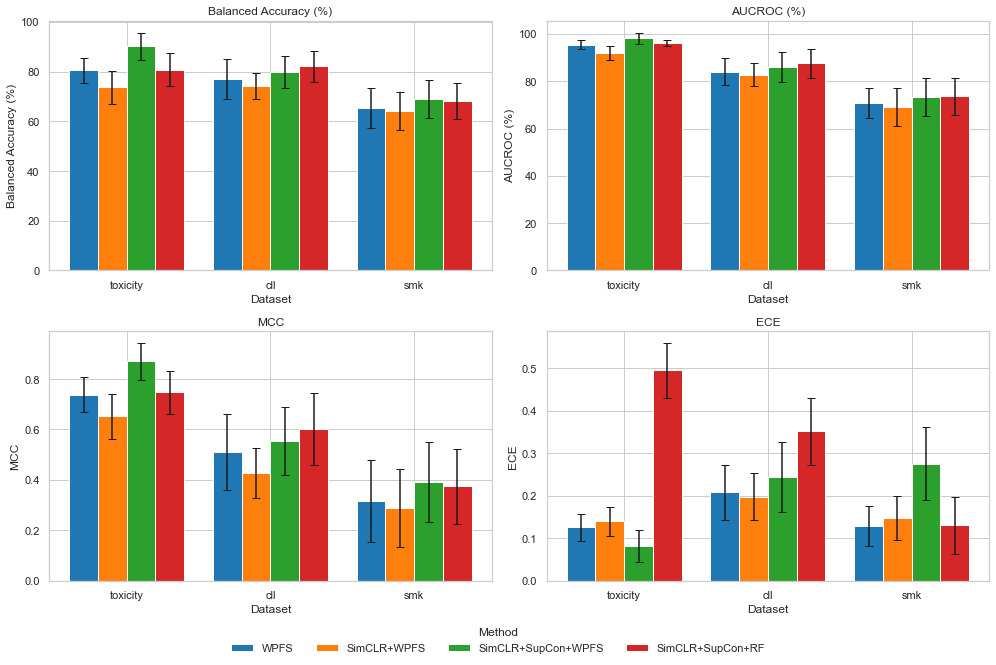

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION --------------------------------------------------------

datasets = ["toxicity", "cll", "smk"]
methods  = ["original", "crm", "crm_supcon", "crm_supcon_rf"]
metrics_info = {
    "balanced_accuracy": {"label": "Balanced Accuracy (%)", "scale": 100},
    "aucroc_macro":      {"label": "AUCROC (%)",         "scale": 100},
    "mcc":               {"label": "MCC",                  "scale": 1},
    "ece":               {"label": "ECE",                  "scale": 1},
}


rename_methods = {
    "original": "WPFS",
    "crm": "SimCLR+WPFS",
    "crm_supcon": "SimCLR+SupCon+WPFS",
    "crm_supcon_rf": "SimCLR+SupCon+RF",
}

# --- AGGREGATE METRICS -----------------------------------------------------

metrics_data = {
    m: {method: [] for method in methods}
    for m in metrics_info
}

for dataset in datasets:
    for method in methods:
        exp_name = f"{dataset}_{method}_v2"
        log_dir = os.path.join("logs", exp_name)
        # collect per-fold runs
        vals = {m: [] for m in metrics_info}
        for fold in os.listdir(log_dir):
            df = pd.read_csv(os.path.join(log_dir, fold, "metrics.csv"))
            vals["balanced_accuracy"].append(df["bestmodel_test/balanced_accuracy"].max())
            vals["aucroc_macro"].append(   df["bestmodel_test/aucroc_macro"].max())
            vals["mcc"].append(            df["bestmodel_test/mcc"].max())
            vals["ece"].append(            df["bestmodel_test/ece"].max())
        # store mean & std per dataset
        for m in metrics_info:
            arr = np.array(vals[m])
            mean = arr.mean() * metrics_info[m]["scale"]
            std  = arr.std()  * metrics_info[m]["scale"]
            metrics_data[m][method].append((mean, std))

# --- PLOT ALL IN ONE -------------------------------------------------------

n_datasets = len(datasets)
n_methods  = len(methods)
x = np.arange(n_datasets)
width = 0.8 / n_methods
colors = plt.get_cmap("tab10").colors

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
axes = axes.ravel()

for ax, (metric, info) in zip(axes, metrics_info.items()):
    for i, method in enumerate(methods):
        means = [metrics_data[metric][method][j][0] for j in range(n_datasets)]
        stds  = [metrics_data[metric][method][j][1] for j in range(n_datasets)]
        ax.bar(
            x + i * width,
            means,
            width=width,
            yerr=stds,
            capsize=4,
            label=rename_methods[method],
            color=colors[i]
        )
    ax.set_title(info["label"])
    ax.set_xticks(x + width * (n_methods - 1) / 2)
    ax.set_xticklabels(datasets)
    ax.set_ylabel(info["label"])
    ax.set_xlabel('Dataset')

# Put a single legend outside
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Method",
           bbox_to_anchor=(0.5, 0), loc="lower center",
           ncol=n_methods, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.savefig('ablation_study.png', dpi=300)
plt.show()